In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, TrainerState, TrainerControl
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
import os
import warnings
import mlflow
import mlflow.pytorch

# Set the MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Some weights of BertForSequenceClassification were not initialized from the model")
warnings.filterwarnings("ignore", message="You should probably TRAIN this model on a down-stream task")

def get_model_size(model):
    """
    Get the size of the model in memory.
    """
    torch.save(model.state_dict(), 'temp_model.pth')
    model_size = os.path.getsize('temp_model.pth')  # Size of the serialized model in bytes
    os.remove('temp_model.pth')  # Remove the temporary file
    return model_size

def calculate_unable_params(model, optimizer):
    """
    Calculate the number of parameters that are unable to be updated during training.
    """
    trainable_params = set(p for p in model.parameters() if p.requires_grad)
    trainable_param_ids = set(id(p) for p in trainable_params)
    optimizer_param_ids = set(id(p) for group in optimizer.param_groups for p in group["params"])
    unable_params_ids = trainable_param_ids - optimizer_param_ids
    unable_params = sum(p.numel() for p in trainable_params if id(p) in unable_params_ids)
    return unable_params

class LoggingCallback(TrainerCallback):
    def on_log(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if state.log_history:
            log_history = state.log_history[-1]
            if 'loss' in log_history:
                mlflow.log_metric("train_loss", log_history['loss'], step=state.global_step)

def run_experiment(layer_name, layers_to_skip, num_samples, batch_size, epochs, experiment_name, dataset_path="customer_support_tickets.csv"):
    print(f"\nRunning experiment: {layer_name}")
    
    # Create a unique output directory
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = f'./results_finetuned_{current_time}'
    os.makedirs(output_dir)
    
    # Load the dataset
    print("Loading dataset...")
    data = pd.read_csv(dataset_path)
    data = data.dropna(subset=['Ticket Description'])
    data = data[['Ticket Description', 'Ticket Type']]
    
    # Sample data if not using the full dataset
    if num_samples == "full":
        data_subset = data
    else:
        data_subset = data.sample(n=int(num_samples), random_state=42)
    
    # Split the data into train and test sets
    print("Splitting data into train and test sets...")
    train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['Ticket Description'], data_subset['Ticket Type'], test_size=0.2, random_state=42)
    
    # Encode labels
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Tokenization
    print("Tokenizing data...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

    # Convert encodings to a format suitable for the trainer
    print("Converting encodings to PyTorch Dataset format...")
    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = MyDataset(train_encodings, train_labels_encoded)
    eval_dataset = MyDataset(test_encodings, test_labels_encoded)

    # Define BERT model
    print("Loading BERT model...")
    model_finetuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

    # Fine-tune by skipping intermediate layers
    if layers_to_skip == 'full':
        print("Not skipping any layers (training with all layers)...")
        model_pretrained = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    else:    
        print("Skipping specified layers...")
        encoder_layers = model_finetuned.bert.encoder.layer
        model_finetuned.bert.encoder.layer = torch.nn.ModuleList([layer for i, layer in enumerate(encoder_layers) if i in layers_to_skip])

        
    # Define training arguments
    print("Defining training arguments...")
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy='epoch',
        logging_dir=f'./logs_finetuned_{current_time}',
        logging_steps=50,  # Log every 50 steps
        num_train_epochs=epochs,
        learning_rate=2e-5,
        save_strategy='epoch',
        load_best_model_at_end=True
    )

    # Define trainer
    print("Initializing trainer...")
    trainer = Trainer(
        model=model_finetuned,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=[LoggingCallback()]
    )

    # Print the current tracking URI
    tracking_uri = mlflow.get_tracking_uri()
    print("Current tracking URI: ", tracking_uri)

    # Set the experiment name to be unique for the entire run
    mlflow.set_experiment(experiment_name)

    # Start an MLflow run with the current time in the name
    with mlflow.start_run(run_name=f"{layer_name}_{batch_size}_{epochs}_{current_time}"):
        mlflow.log_param("layer_name", layer_name)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("layers_to_skip", layers_to_skip)

        # Train and evaluate model
        print("Training and evaluating model...")
        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time

        # Predict test data
        print("Predicting test data...")
        start_time = time.time()
        preds = trainer.predict(eval_dataset)
        prediction_time = time.time() - start_time

        # Calculate metrics
        print("Calculating metrics...")
        accuracy = accuracy_score(test_labels_encoded, preds.predictions.argmax(axis=1))
        precision = precision_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
        recall = recall_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
        f1 = f1_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')

        # Additional metrics for resource and efficiency comparison
        model_size = get_model_size(model_finetuned)
        num_params = sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("training_time", training_time)
        mlflow.log_metric("prediction_time", prediction_time)
        mlflow.log_metric("model_size", model_size)
        mlflow.log_metric("num_params", num_params)

        # Save the model
        mlflow.pytorch.log_model(model_finetuned, "model")

        # Print results
        print("Results for Layer:", layer_name)
        results_df = pd.DataFrame({
            'Layer Name': [layer_name], 
            'Batch Size': [batch_size],
            'Epochs': [epochs],
            'Accuracy': [accuracy], 
            'Precision': [precision], 
            'Recall': [recall], 
            'F1': [f1], 
            'Training Time': [training_time],
            'Prediction Time': [prediction_time],
            'Model Size': [model_size],
            'Number of Parameters': [num_params],
        })
        display(results_df)

    return results_df




2024-07-14 10:29:40.233203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mlflow.get_tracking_uri()

'http://127.0.0.1:5000'

In [3]:
# Example usage:
layers_to_skip = [
    np.random.choice(range(12), 6, replace=False),  # Random skipping
    np.random.choice(range(12), 6, replace=False),
    np.random.choice(range(12), 6, replace=False),
    [i for i in range(1, 12, 2)],  # Skipping odd layers
    [i for i in range(0, 12, 2)],  # Skipping even layers
    [1, 2, 3, 4, 5, 6, 7, 8],
    [5, 6, 7, 8, 9, 10, 11],
    []  # No skipping (full pre-trained)
]

num_samples = '50'  # Specify the number of samples, or "full" for the full dataset
batch_sizes = [8, 16]  # Example batch sizes
epoch_list = [3, 5]  # Example numbers of epochs

# Set the experiment name
experiment_name = "BERT_Layer_Skipping_Experiment_50_samples"

results_dfs = []
display(layers_to_skip)
sorted_layers_to_skip = [sorted(layer.tolist()) if isinstance(layer, np.ndarray) else layer for layer in layers_to_skip]
display(sorted_layers_to_skip)

# Run experiments for each configuration
for batch_size in batch_sizes:
    for epochs in epoch_list:
        for layers in sorted_layers_to_skip:
            if len(layers) == 0:
                name = "Full_Pretrained"
                layers = 'full'
            else:
                name = "Layer_" + "_".join([str(layer) for layer in layers]) + "_Skipped"
            results_df = run_experiment(name, layers, num_samples, batch_size, epochs, experiment_name)
            results_dfs.append(results_df)

# Combine results into a single DataFrame
combined_results = pd.concat(results_dfs, ignore_index=True)
print("\nCombined Results:")
display(combined_results)

[array([ 8,  6,  7,  4, 11,  2]),
 array([ 2,  9,  6,  0,  7, 11]),
 array([ 9,  2,  0, 11,  4,  3]),
 [1, 3, 5, 7, 9, 11],
 [0, 2, 4, 6, 8, 10],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9, 10, 11],
 []]

[[2, 4, 6, 7, 8, 11],
 [0, 2, 6, 7, 9, 11],
 [0, 2, 3, 4, 9, 11],
 [1, 3, 5, 7, 9, 11],
 [0, 2, 4, 6, 8, 10],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9, 10, 11],
 []]


Running experiment: Layer_2_4_6_7_8_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Skipping specified layers...
Defining training arguments...
Initializing trainer...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
2024/07/14 10:29:58 INFO mlflow.tracking.fluent: Experiment with name 'BERT_Layer_Skipping_Experiment_50_samples' does not exist. Creating a new experiment.


Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.649509
2,No log,1.665115
3,No log,1.671622


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_2_4_6_7_8_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_2_4_6_7_8_11_Skipped,8,3,0.2,0.04,0.2,0.066667,43.800734,1.328007,267876775,66958853



Running experiment: Layer_0_2_6_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.631025
2,No log,1.649925
3,No log,1.656711


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_6_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_6_7_9_11_Skipped,8,3,0.2,0.04,0.2,0.066667,39.881582,1.102956,267876775,66958853



Running experiment: Layer_0_2_3_4_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.623294
2,No log,1.644648
3,No log,1.654547


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_3_4_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_3_4_9_11_Skipped,8,3,0.2,0.04,0.2,0.066667,45.541824,1.114424,267876775,66958853



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.635312
2,No log,1.651546
3,No log,1.656912


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_3_5_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_3_5_7_9_11_Skipped,8,3,0.2,0.04,0.2,0.066667,61.933895,1.0892,267876775,66958853



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.682820
2,No log,1.680646
3,No log,1.684602


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_4_6_8_10_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_4_6_8_10_Skipped,8,3,0.2,0.04,0.2,0.066667,40.276848,1.105958,267876775,66958853



Running experiment: Layer_1_2_3_4_5_6_7_8_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.711183
2,No log,1.719220
3,No log,1.724874


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_2_3_4_5_6_7_8_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_2_3_4_5_6_7_8_Skipped,8,3,0.1,0.011111,0.1,0.02,51.191235,1.456496,324592455,81134597



Running experiment: Layer_5_6_7_8_9_10_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.635782
2,No log,1.636610
3,No log,1.642674


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_5_6_7_8_9_10_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_5_6_7_8_9_10_11_Skipped,8,3,0.2,0.04,0.2,0.066667,62.30635,1.275943,296234615,74046725



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.693979
2,No log,1.714190
3,No log,1.724000


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Full_Pretrained


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Full_Pretrained,8,3,0.2,0.044444,0.2,0.072727,84.0112,2.164331,438023751,109486085



Running experiment: Layer_2_4_6_7_8_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.648533
2,No log,1.668473
3,No log,1.689042
4,No log,1.701593
5,No log,1.704176


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_2_4_6_7_8_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_2_4_6_7_8_11_Skipped,8,5,0.2,0.04,0.2,0.066667,67.387966,1.117311,267876775,66958853



Running experiment: Layer_0_2_6_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.695467
2,No log,1.726738
3,No log,1.725413
4,No log,1.663684
5,No log,1.654955


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_6_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_6_7_9_11_Skipped,8,5,0.3,0.091667,0.3,0.14,76.548832,1.105743,267876775,66958853



Running experiment: Layer_0_2_3_4_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.698761
2,No log,1.726155
3,No log,1.740525
4,No log,1.730538
5,No log,1.725510


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_3_4_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_3_4_9_11_Skipped,8,5,0.2,0.04,0.2,0.066667,80.846512,1.108112,267876775,66958853



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.711179
2,No log,1.750013
3,No log,1.746570
4,No log,1.716387
5,No log,1.708159


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_3_5_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_3_5_7_9_11_Skipped,8,5,0.2,0.044444,0.2,0.072727,88.309435,1.106199,267876775,66958853



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.779230
2,No log,1.808016
3,No log,1.805584
4,No log,1.767960
5,No log,1.762218


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_4_6_8_10_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_4_6_8_10_Skipped,8,5,0.2,0.04,0.2,0.066667,78.560884,1.118216,267876775,66958853



Running experiment: Layer_1_2_3_4_5_6_7_8_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.700826
2,No log,1.703254
3,No log,1.663491
4,No log,1.643940
5,No log,1.647920


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_2_3_4_5_6_7_8_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_2_3_4_5_6_7_8_Skipped,8,5,0.3,0.090476,0.3,0.138889,114.578964,1.485055,324592455,81134597



Running experiment: Layer_5_6_7_8_9_10_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.729956
2,No log,1.742107
3,No log,1.728831
4,No log,1.718573
5,No log,1.718195


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_5_6_7_8_9_10_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_5_6_7_8_9_10_11_Skipped,8,5,0.3,0.144444,0.3,0.172727,74.708119,1.28327,296234615,74046725



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.639049
2,No log,1.737568
3,No log,1.810519
4,No log,1.742983
5,No log,1.707048


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Full_Pretrained


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Full_Pretrained,8,5,0.2,0.1125,0.2,0.122222,141.378661,2.212574,438023751,109486085



Running experiment: Layer_2_4_6_7_8_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.723221
2,No log,1.726571
3,No log,1.728192


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_2_4_6_7_8_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_2_4_6_7_8_11_Skipped,16,3,0.2,0.04,0.2,0.066667,38.761762,1.014585,267876775,66958853



Running experiment: Layer_0_2_6_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.620378
2,No log,1.633731
3,No log,1.639639


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_6_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_6_7_9_11_Skipped,16,3,0.2,0.04,0.2,0.066667,39.171347,1.010417,267876775,66958853



Running experiment: Layer_0_2_3_4_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.613867
2,No log,1.622592
3,No log,1.628096


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_3_4_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_3_4_9_11_Skipped,16,3,0.2,0.04,0.2,0.066667,63.321596,1.02499,267876775,66958853



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.615580
2,No log,1.636522
3,No log,1.642974


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_3_5_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_3_5_7_9_11_Skipped,16,3,0.2,0.04,0.2,0.066667,41.436651,1.020503,267876775,66958853



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.672319
2,No log,1.680496
3,No log,1.686146


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_4_6_8_10_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_4_6_8_10_Skipped,16,3,0.3,0.091667,0.3,0.14,37.401947,1.01207,267876775,66958853



Running experiment: Layer_1_2_3_4_5_6_7_8_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.701041
2,No log,1.712372
3,No log,1.717004


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_2_3_4_5_6_7_8_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_2_3_4_5_6_7_8_Skipped,16,3,0.0,0.0,0.0,0.0,80.718962,1.362901,324592455,81134597



Running experiment: Layer_5_6_7_8_9_10_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.629086
2,No log,1.638301
3,No log,1.643696


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_5_6_7_8_9_10_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_5_6_7_8_9_10_11_Skipped,16,3,0.2,0.04,0.2,0.066667,46.1282,1.191086,296234615,74046725



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.680166
2,No log,1.722782
3,No log,1.756011


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Full_Pretrained


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Full_Pretrained,16,3,0.2,0.04,0.2,0.066667,79.161607,2.092035,438023751,109486085



Running experiment: Layer_2_4_6_7_8_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.640912
2,No log,1.661244
3,No log,1.682863
4,No log,1.697360
5,No log,1.699409


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_2_4_6_7_8_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_2_4_6_7_8_11_Skipped,16,5,0.2,0.04,0.2,0.066667,99.275655,1.091307,267876775,66958853



Running experiment: Layer_0_2_6_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.703800
2,No log,1.716565
3,No log,1.717008
4,No log,1.707593
5,No log,1.702219


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_6_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_6_7_9_11_Skipped,16,5,0.2,0.04,0.2,0.066667,75.238935,1.023712,267876775,66958853



Running experiment: Layer_0_2_3_4_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.708124
2,No log,1.712950
3,No log,1.714267
4,No log,1.710605
5,No log,1.704630


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_3_4_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_3_4_9_11_Skipped,16,5,0.2,0.04,0.2,0.066667,61.474701,1.026092,267876775,66958853



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.726096
2,No log,1.732217
3,No log,1.725858
4,No log,1.710140
5,No log,1.700270


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_3_5_7_9_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_3_5_7_9_11_Skipped,16,5,0.2,0.044444,0.2,0.072727,91.698465,0.994234,267876775,66958853



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.743820
2,No log,1.767878
3,No log,1.772762
4,No log,1.761850
5,No log,1.754607


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_4_6_8_10_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_4_6_8_10_Skipped,16,5,0.2,0.04,0.2,0.066667,64.872113,1.010842,267876775,66958853



Running experiment: Layer_1_2_3_4_5_6_7_8_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.715133
2,No log,1.752054
3,No log,1.724686
4,No log,1.688481
5,No log,1.675473


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_2_3_4_5_6_7_8_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_2_3_4_5_6_7_8_Skipped,16,5,0.3,0.1,0.3,0.146667,98.323153,1.360364,324592455,81134597



Running experiment: Layer_5_6_7_8_9_10_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.702000
2,No log,1.711024
3,No log,1.700898
4,No log,1.690680
5,No log,1.689898


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_5_6_7_8_9_10_11_Skipped


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_5_6_7_8_9_10_11_Skipped,16,5,0.2,0.04,0.2,0.066667,80.67431,1.196581,296234615,74046725



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Current tracking URI:  http://127.0.0.1:5000
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.711445
2,No log,1.735429
3,No log,1.742456
4,No log,1.731927
5,No log,1.723112


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Full_Pretrained


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Full_Pretrained,16,5,0.2,0.04,0.2,0.066667,154.401199,2.140509,438023751,109486085



Combined Results:


,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_2_4_6_7_8_11_Skipped,8,3,0.2,0.040000,0.2,0.066667,43.800734,1.328007,267876775,66958853
1,Layer_0_2_6_7_9_11_Skipped,8,3,0.2,0.040000,0.2,0.066667,39.881582,1.102956,267876775,66958853
2,Layer_0_2_3_4_9_11_Skipped,8,3,0.2,0.040000,0.2,0.066667,45.541824,1.114424,267876775,66958853
3,Layer_1_3_5_7_9_11_Skipped,8,3,0.2,0.040000,0.2,0.066667,61.933895,1.089200,267876775,66958853
4,Layer_0_2_4_6_8_10_Skipped,8,3,0.2,0.040000,0.2,0.066667,40.276848,1.105958,267876775,66958853
5,Layer_1_2_3_4_5_6_7_8_Skipped,8,3,0.1,0.011111,0.1,0.020000,51.191235,1.456496,324592455,81134597
6,Layer_5_6_7_8_9_10_11_Skipped,8,3,0.2,0.040000,0.2,0.066667,62.306350,1.275943,296234615,74046725
7,Full_Pretrained,8,3,0.2,0.044444,0.2,0.072727,84.011200,2.164331,438023751,109486085
8,Layer_2_4_6_7_8_11_Skipped,8,5,0.2,0.040000,0.2,0.066667,67.387966,1.117311,267876775,66958853
9,Layer_0_2_6_7_9_11_Skipped,8,5,0.3,0.091667,0.3,0.140000,76.548832,1.105743,267876775,66958853


In [6]:
# Sort DataFrame based on F1 score
combined_results_sorted = combined_results.sort_values(by='F1', ascending=False)
combined_results_sorted

,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
14,Layer_5_6_7_8_9_10_11_Skipped,8,5,0.3,0.144444,0.3,0.172727,74.708119,1.283270,296234615,74046725
29,Layer_1_2_3_4_5_6_7_8_Skipped,16,5,0.3,0.100000,0.3,0.146667,98.323153,1.360364,324592455,81134597
9,Layer_0_2_6_7_9_11_Skipped,8,5,0.3,0.091667,0.3,0.140000,76.548832,1.105743,267876775,66958853
20,Layer_0_2_4_6_8_10_Skipped,16,3,0.3,0.091667,0.3,0.140000,37.401947,1.012070,267876775,66958853
13,Layer_1_2_3_4_5_6_7_8_Skipped,8,5,0.3,0.090476,0.3,0.138889,114.578964,1.485055,324592455,81134597
15,Full_Pretrained,8,5,0.2,0.112500,0.2,0.122222,141.378661,2.212574,438023751,109486085
27,Layer_1_3_5_7_9_11_Skipped,16,5,0.2,0.044444,0.2,0.072727,91.698465,0.994234,267876775,66958853
7,Full_Pretrained,8,3,0.2,0.044444,0.2,0.072727,84.011200,2.164331,438023751,109486085
11,Layer_1_3_5_7_9_11_Skipped,8,5,0.2,0.044444,0.2,0.072727,88.309435,1.106199,267876775,66958853
28,Layer_0_2_4_6_8_10_Skipped,16,5,0.2,0.040000,0.2,0.066667,64.872113,1.010842,267876775,66958853


In [7]:

# Sort DataFrame based on Accuracy score
combined_results_sorted = combined_results.sort_values(by='Accuracy', ascending=False)
combined_results_sorted

,Layer Name,Batch Size,Epochs,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
9,Layer_0_2_6_7_9_11_Skipped,8,5,0.3,0.091667,0.3,0.140000,76.548832,1.105743,267876775,66958853
29,Layer_1_2_3_4_5_6_7_8_Skipped,16,5,0.3,0.100000,0.3,0.146667,98.323153,1.360364,324592455,81134597
14,Layer_5_6_7_8_9_10_11_Skipped,8,5,0.3,0.144444,0.3,0.172727,74.708119,1.283270,296234615,74046725
13,Layer_1_2_3_4_5_6_7_8_Skipped,8,5,0.3,0.090476,0.3,0.138889,114.578964,1.485055,324592455,81134597
20,Layer_0_2_4_6_8_10_Skipped,16,3,0.3,0.091667,0.3,0.140000,37.401947,1.012070,267876775,66958853
0,Layer_2_4_6_7_8_11_Skipped,8,3,0.2,0.040000,0.2,0.066667,43.800734,1.328007,267876775,66958853
19,Layer_1_3_5_7_9_11_Skipped,16,3,0.2,0.040000,0.2,0.066667,41.436651,1.020503,267876775,66958853
22,Layer_5_6_7_8_9_10_11_Skipped,16,3,0.2,0.040000,0.2,0.066667,46.128200,1.191086,296234615,74046725
23,Full_Pretrained,16,3,0.2,0.040000,0.2,0.066667,79.161607,2.092035,438023751,109486085
24,Layer_2_4_6_7_8_11_Skipped,16,5,0.2,0.040000,0.2,0.066667,99.275655,1.091307,267876775,66958853


In [1]:

combined_results_sorted.to_csv('Result_saved_50_samples_July_14_2024_results.csv',index=False)

NameError: name 'combined_results_sorted' is not defined

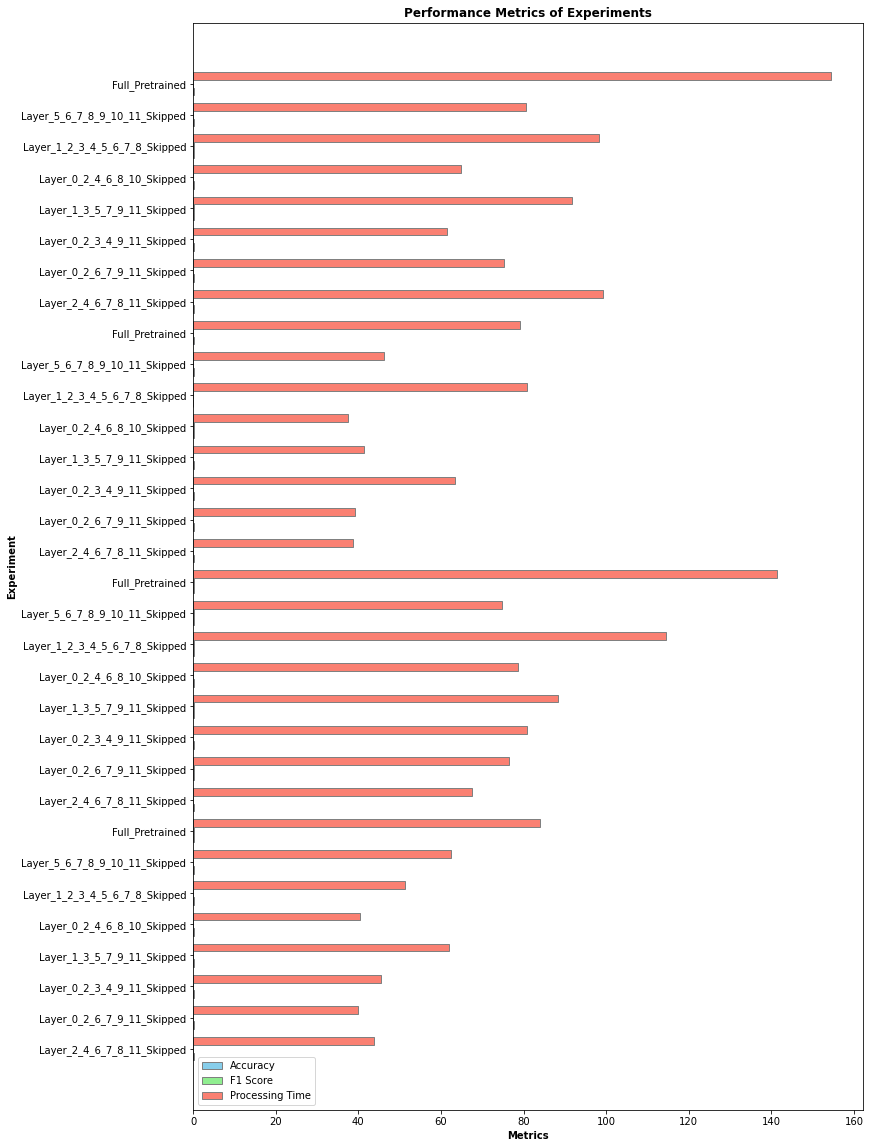

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the relevant data from the combined results DataFrame
experiment_names = combined_results['Layer Name']
accuracy = combined_results['Accuracy']
f1_score = combined_results['F1']
processing_time = combined_results['Training Time']

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(experiment_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the results
plt.figure(figsize=(12, 20))

plt.barh(r1, accuracy, color='skyblue', height=bar_width, edgecolor='grey', label='Accuracy')
plt.barh(r2, f1_score, color='lightgreen', height=bar_width, edgecolor='grey', label='F1 Score')
plt.barh(r3, processing_time, color='salmon', height=bar_width, edgecolor='grey', label='Processing Time')

# Add labels, tick labels, and title
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Experiment', fontweight='bold')
plt.yticks([r + bar_width for r in range(len(experiment_names))], experiment_names)
plt.title('Performance Metrics of Experiments', fontweight='bold')
plt.legend()

plt.show()

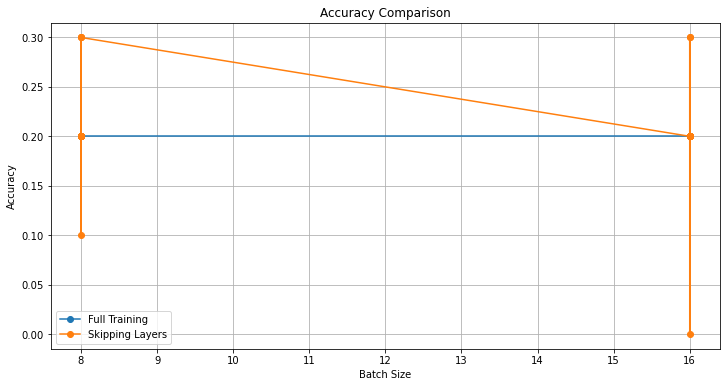

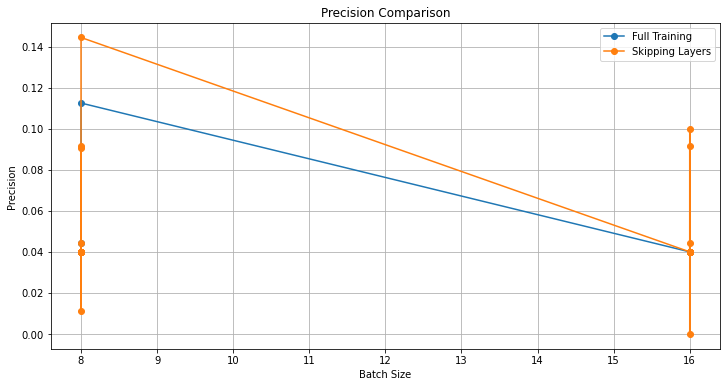

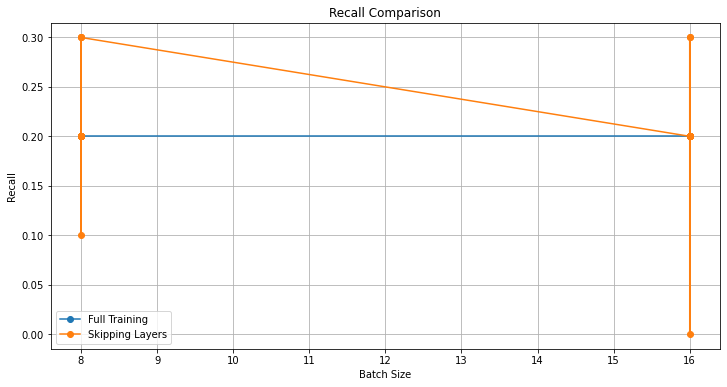

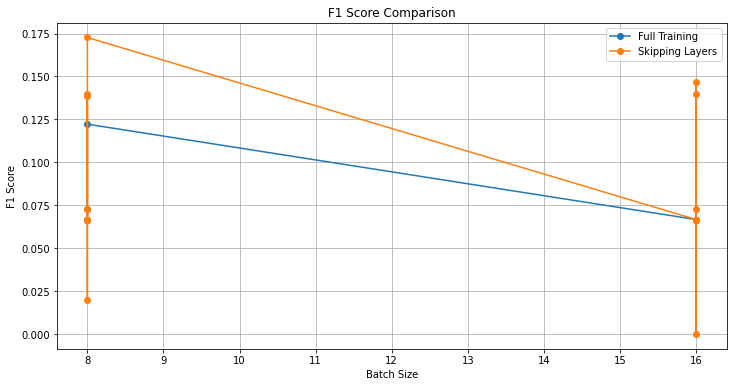

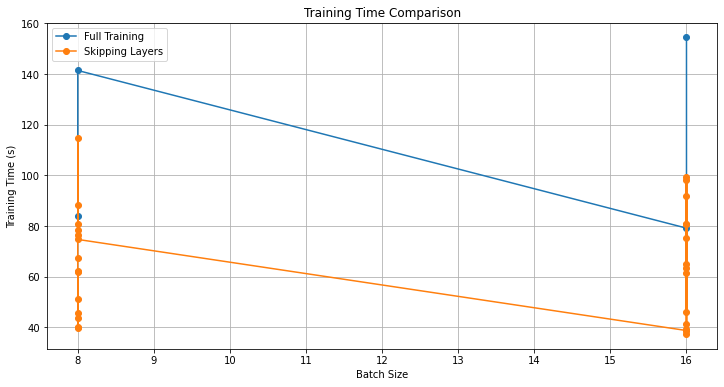

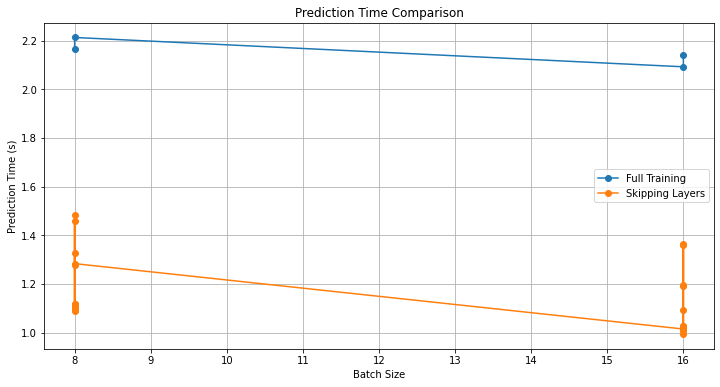

In [12]:
import matplotlib.pyplot as plt

# Separate results for full training and skipping layers
full_training_results = combined_results[combined_results['Layer Name'] == 'Full_Pretrained']
skipping_layer_results = combined_results[combined_results['Layer Name'] != 'Full_Pretrained']

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(full_training_results['Batch Size'], full_training_results['Accuracy'], label='Full Training', marker='o')
plt.plot(skipping_layer_results['Batch Size'], skipping_layer_results['Accuracy'], label='Skipping Layers', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision comparison
plt.figure(figsize=(12, 6))
plt.plot(full_training_results['Batch Size'], full_training_results['Precision'], label='Full Training', marker='o')
plt.plot(skipping_layer_results['Batch Size'], skipping_layer_results['Precision'], label='Skipping Layers', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot recall comparison
plt.figure(figsize=(12, 6))
plt.plot(full_training_results['Batch Size'], full_training_results['Recall'], label='Full Training', marker='o')
plt.plot(skipping_layer_results['Batch Size'], skipping_layer_results['Recall'], label='Skipping Layers', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 score comparison
plt.figure(figsize=(12, 6))
plt.plot(full_training_results['Batch Size'], full_training_results['F1'], label='Full Training', marker='o')
plt.plot(skipping_layer_results['Batch Size'], skipping_layer_results['F1'], label='Skipping Layers', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot training time comparison
plt.figure(figsize=(12, 6))
plt.plot(full_training_results['Batch Size'], full_training_results['Training Time'], label='Full Training', marker='o')
plt.plot(skipping_layer_results['Batch Size'], skipping_layer_results['Training Time'], label='Skipping Layers', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediction time comparison
plt.figure(figsize=(12, 6))
plt.plot(full_training_results['Batch Size'], full_training_results['Prediction Time'], label='Full Training', marker='o')
plt.plot(skipping_layer_results['Batch Size'], skipping_layer_results['Prediction Time'], label='Skipping Layers', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Prediction Time (s)')
plt.title('Prediction Time Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
!pwd

/Users/monu/Thesis_July14
